In [133]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

from skimage.transform import resize
from sklearn.metrics import accuracy_score

In [134]:
    # Flipped Images with ratio
    def random_flipped_img(images, labels, flip_ratio):
        num_flips = int(len(images) * flip_ratio)
        random_choice = np.random.choice(len(images), num_flips, replace=False)
        new_images = []
        new_labels = []
        new_classes = []
        for i, (img,label) in enumerate(zip(images,labels)):
            if i in random_choice:
                flipped_img = np.flip(img, axis=0)
                new_images.append(flipped_img)
                new_labels.append(1) # 1 for flip
                new_classes.append(label)
            else:
                new_images.append(img)
                new_labels.append(0) # 0 for not flip
                new_classes.append(label)
        return new_images, new_labels, new_classes

    # Load dataset
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    # Normalize the RGB values to be between 0 and 1
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    # Ratio of train and test (8:2)
    train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


    # Total images of train and test set after apply ratio
    total_train_num = int(len(train_images))
    total_test_num = int(len(test_images))

    print("Total images of train set:",total_train_num)
    print("Total images of test set: ", total_test_num)

    # Select random images from train set
    random_indices_train = np.random.choice(len(train_images), total_train_num, replace=False)
    selected_train_images = train_images[random_indices_train]
    selected_train_labels = train_labels[random_indices_train]

    # Select random images from test set
    random_indices_test = np.random.choice(len(test_images), total_test_num, replace=False)
    selected_test_images = test_images[random_indices_test]
    selected_test_labels = test_labels[random_indices_test]

    # Fiptting ratio
    flip_ratio = 0.5
    # train - images and labels after flippting randomly
    flipped_train_images, flipped_train_labels, flipped_train_classes = random_flipped_img(selected_train_images, selected_train_labels, flip_ratio)

    # test - images and labels after flippting randomly
    flipped_test_images, flipped_test_labels, flipped_test_classes = random_flipped_img(selected_test_images, selected_test_labels, flip_ratio)

Total images of train set: 48000
Total images of test set:  12000


In [135]:
# Resize images
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = resize(image, (28, 28))
        if len(resized_image.shape) == 2:
            resized_image = np.expand_dims(resized_image, axis=-1)
        resized_image = np.mean(resized_image, axis=2) 
        resized_images.append(resized_image)
    return np.array(resized_images)

# Convert to numpy arrays and normalize
train_images = np.array(flipped_train_images) / 255.0
train_labels = np.array(flipped_train_labels)
train_classes = np.array(flipped_train_classes)

test_images = np.array(flipped_test_images) / 255.0
test_labels = np.array(flipped_test_labels)
test_classes = np.array(flipped_test_classes)

train_images_resized = resize_images(train_images)
test_images_resized = resize_images(test_images)
input_shape = train_images_resized[0].shape

# Adjust Values
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0005,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    #tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    #tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    train_images_resized,
    train_labels,
    epochs=10,
    batch_size=64, # 16 32 64 128 256 vv 
    validation_data=(test_images_resized, test_labels)
)

Epoch 1/10
750/750 [==============================] - 27s 34ms/step - loss: 0.6940 - accuracy: 0.5654 - val_loss: 0.5097 - val_accuracy: 0.7376
Epoch 2/10
750/750 [==============================] - 21s 28ms/step - loss: 0.3843 - accuracy: 0.8169 - val_loss: 0.2650 - val_accuracy: 0.8906
Epoch 3/10
750/750 [==============================] - 25s 33ms/step - loss: 0.2742 - accuracy: 0.8784 - val_loss: 0.2351 - val_accuracy: 0.8996
Epoch 4/10
750/750 [==============================] - 22s 30ms/step - loss: 0.2409 - accuracy: 0.8938 - val_loss: 0.2023 - val_accuracy: 0.9081
Epoch 5/10
750/750 [==============================] - 26s 35ms/step - loss: 0.2151 - accuracy: 0.9061 - val_loss: 0.1893 - val_accuracy: 0.9185
Epoch 6/10
750/750 [==============================] - 24s 32ms/step - loss: 0.1953 - accuracy: 0.9169 - val_loss: 0.1596 - val_accuracy: 0.9373
Epoch 7/10
750/750 [==============================] - 22s 30ms/step - loss: 0.1792 - accuracy: 0.9260 - val_loss: 0.1441 - val_accuracy:

In [136]:
# CNN prediction
predicted_labels = []

for i in range(len(test_images_resized)):
    # Make prediction on a single image
    prediction = model.predict(np.expand_dims(test_images_resized[i], axis=0))
    # Add label after prediction into array
    predicted_label = np.argmax(prediction)
    predicted_labels.append(predicted_label)

print("Predicted labels of images:", predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 17ms/step
Predicted labels of images: [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1

In [164]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest model
# Increase accuracy => increase number of trees
RF = RandomForestClassifier(n_estimators=100, random_state=20)

# Flatten the images for compatibility with non-CNN models
train_images_flattened = tf.reshape(train_images_resized, (train_images_resized.shape[0], -1))
test_images_flattened = tf.reshape(test_images_resized, (test_images_resized.shape[0], -1))
# Train the Random Forest Classifier
RF.fit(train_images_flattened, train_labels)
# Random Forest Prediction -> Use as Replace Solution -> Will be update on future later
predicted_labels_RF = RF.predict(test_images_flattened)
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels_RF)
print(test_labels)
print(predicted_labels_RF)
print("Accuracy:", accuracy)

[0 0 0 ... 1 0 1]
[0 0 0 ... 1 0 1]
Accuracy: 0.9848333333333333


In [167]:
from collections import Counter

# Mapping of classes
classes = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
# Mapping predicted labels to class names
predicted_class_names = [classes[label] for label in flipped_test_classes]

# Displaying predicted class names
print("Predicted class names of images:", predicted_class_names)

# Count occurrences of each class in predicted class names
class_counts = Counter(predicted_class_names)

# Display class counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} occurrences")
    
# def plot_images(images):
#     num_images = len(images) 
#     num_rows = int(num_images ** 0.5) + 1
#     num_cols = (num_images // num_rows) + 1
#     plt.figure(figsize=(25, 25))  # Adjust the figsize here to make the images bigger
#     for i in range(num_images):
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(images[i], cmap='gray')
#         plt.title(f"Class name: {classes[flipped_test_classes[i]]}\nTrue Label: {flipped_test_labels[i]}\nPredicted label: {predicted_labels[i]}\n{i}")
#         plt.axis('off')
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=1, hspace=1)
#     plt.show()

# # Plot the images with their titles, labels, and predicted classes
# plot_images(flipped_test_images[:200])

# Initialize a dictionary to store misclassification counts for each class
class_misclassified_counts = {class_name: {'count': 0, 'positions': []} for class_name in classes.values()}

# Iterate through true labels and predicted labels simultaneously
for i, (true_label, predicted_label, class_name) in enumerate(zip(flipped_test_labels, predicted_labels, predicted_class_names)):
    # Check if true label is different from predicted label
    if true_label != predicted_label:
        # Increment misclassification count for the corresponding class
        class_misclassified_counts[class_name]['count'] += 1
        # Append the position 'i' to the list of positions for the corresponding class
        class_misclassified_counts[class_name]['positions'].append(i)

print("\n")
# Display misclassification counts for each class
for class_name, info in class_misclassified_counts.items():
    print(f"Class: {class_name}, Misclassified Count: {info['count']}, Positions: {info['positions']}")


# Sort the misclassification counts dictionary by count in descending order
sorted_misclassified_counts = sorted(class_misclassified_counts.items(), key=lambda x: x[1]['count'], reverse=True)

# Display the top 3 classes with the highest misclassification counts
print("\n\nTop 3 classes with the highest misclassification counts:")
for i, (class_name, info) in enumerate(sorted_misclassified_counts[:3]):
    print(f"{i+1}. Class: {class_name}, Misclassified Count: {info['count']}, Positions: {info['positions']}")
    
    

Predicted class names of images: ['Sandal', 'Coat', 'Sandal', 'Sneaker', 'Pullover', 'T-Shirt', 'Sneaker', 'Ankle Boot', 'Trouser', 'Shirt', 'Pullover', 'Sneaker', 'Dress', 'Sneaker', 'Ankle Boot', 'Trouser', 'Pullover', 'Bag', 'Coat', 'Shirt', 'Bag', 'Coat', 'Dress', 'Trouser', 'Trouser', 'Dress', 'T-Shirt', 'T-Shirt', 'Trouser', 'Coat', 'Dress', 'T-Shirt', 'Coat', 'Shirt', 'Pullover', 'Shirt', 'Trouser', 'Dress', 'Shirt', 'Dress', 'Shirt', 'Ankle Boot', 'Trouser', 'Bag', 'T-Shirt', 'Shirt', 'T-Shirt', 'Dress', 'T-Shirt', 'Sneaker', 'Trouser', 'Sneaker', 'Coat', 'Sneaker', 'Coat', 'Coat', 'Coat', 'Bag', 'Pullover', 'Shirt', 'Ankle Boot', 'Bag', 'Shirt', 'Trouser', 'Trouser', 'Sandal', 'Bag', 'Trouser', 'Trouser', 'Coat', 'Sandal', 'Ankle Boot', 'Pullover', 'Dress', 'Trouser', 'Shirt', 'Dress', 'Ankle Boot', 'Trouser', 'Dress', 'Sandal', 'Sandal', 'Pullover', 'Bag', 'Dress', 'Coat', 'Dress', 'T-Shirt', 'Sneaker', 'Shirt', 'Sneaker', 'Bag', 'Pullover', 'Pullover', 'Bag', 'Pullover', 'Co

C:\Users\Acer\AppData\Local\Temp\ipykernel_8724\2148168533.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, num_images_per_class, i * num_images_per_class + j + 1)


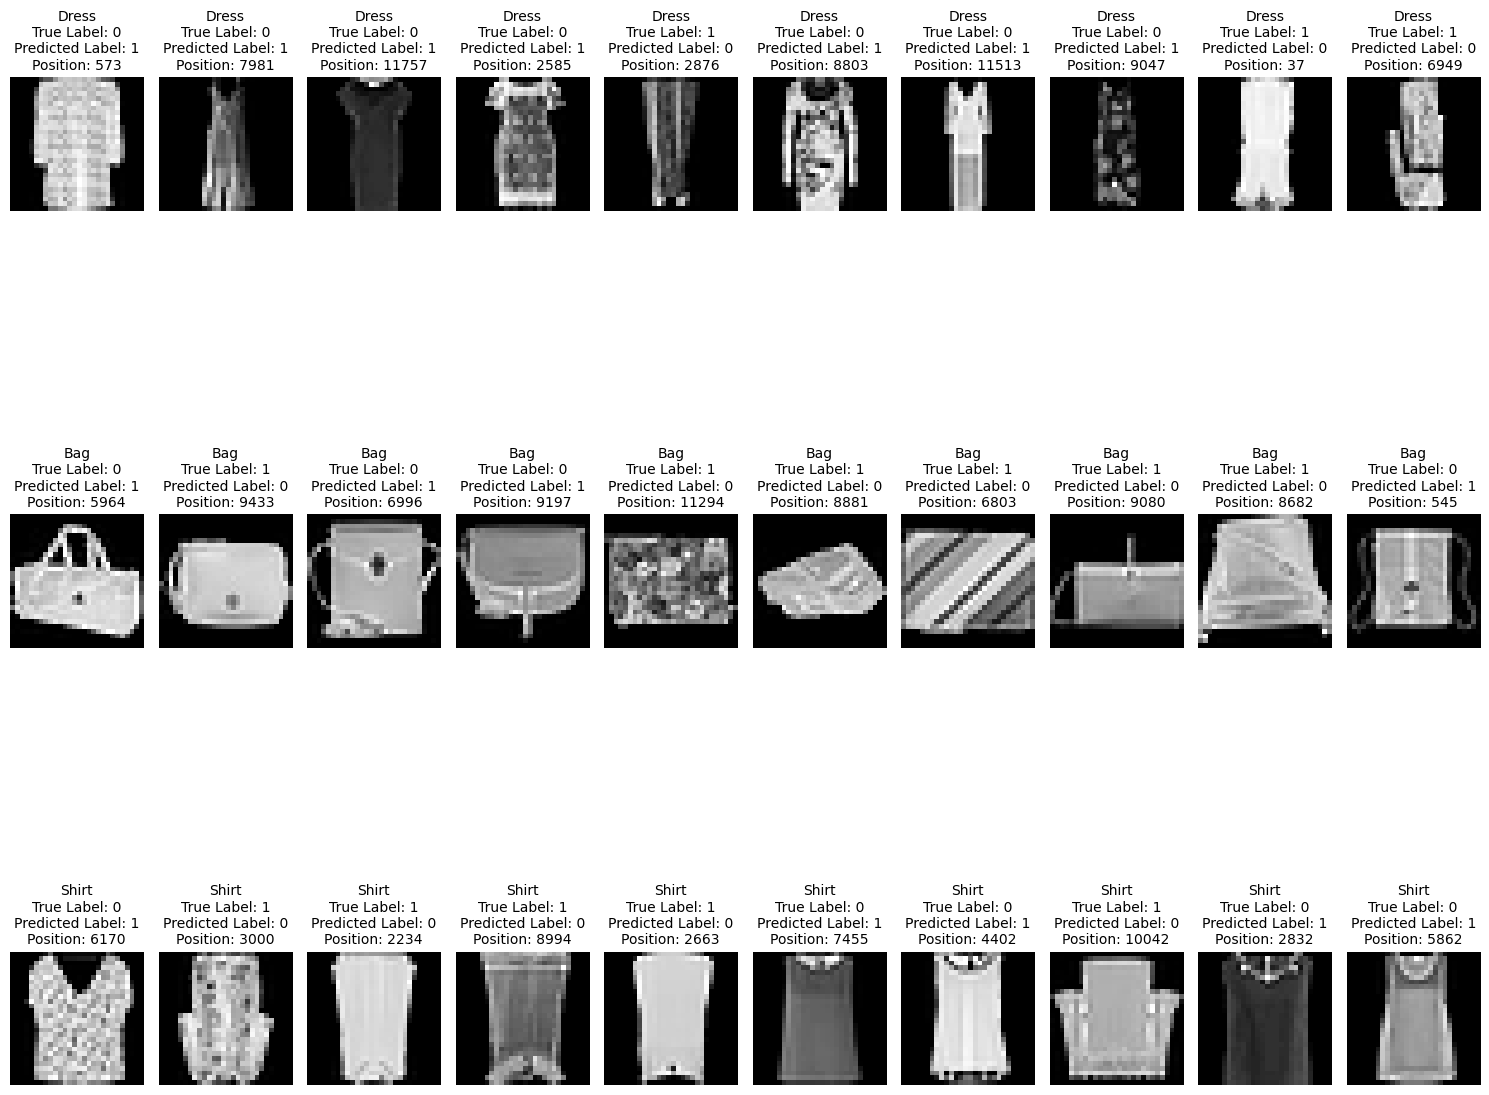

In [190]:
import random
import matplotlib.pyplot as plt

# Initialize a list to store selected positions
selected_positions = []

# Define the number of images to select per class
num_images_per_class = 10

# Iterate through the top 3 misclassified classes
for class_name, info in sorted_misclassified_counts[:3]:
    # Shuffle the positions for each class
    random.shuffle(info['positions'])
    # Select up to num_images_per_class positions from each class
    selected_positions.extend(info['positions'][:num_images_per_class])

# Plot 10 random images from each of the top 3 misclassified classes
plt.figure(figsize=(15, 15))
for i, (class_name, info) in enumerate(sorted_misclassified_counts[:3]):
    # Shuffle the positions for each class
    random.shuffle(info['positions'])
    # Select up to num_images_per_class positions from each class
    class_selected_positions = info['positions'][:num_images_per_class]
    # Plot each class in its own square subplot
    plt.subplot(3, 1, i + 1)
    for j, position in enumerate(class_selected_positions):
        plt.subplot(3, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(flipped_test_images[position], cmap='gray')
        plt.title(f"{class_name}\nTrue Label: {flipped_test_labels[position]}\nPredicted Label: {predicted_labels[position]}\nPosition: {position}", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()
